In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import matplotlib.pyplot as plt
%run definitions.ipynb

#from definitions import IsScalar, Thresh, Hamming, Perturb, check_binary_array, generate_array, Energy, stable_state, find_thresh, num_of_cross_talk, attenuator



In [2]:
W = generate_array(3,1024)

#TEST
#V = np.array([
#    [1] * 20 + [0] * 80,
#    [0] * 80 + [1] * 20
#    ], dtype=int)

W.shape

(3, 1024)

In [3]:
while (1):
    W_not = Perturb(W,p=450)
    tempW = W_not@W_not.T
    is_diagonal = True 
    for i in range(tempW.shape[0]):
        for j in range(tempW.shape[1]):
            if i != j and tempW[i][j] >= 650:
                is_diagonal = False
                break

    if is_diagonal:
        break

W=W_not

P1 = Perturb(W, p=200)
P2 = Perturb(W, p=300)

WS = np.vstack((W, P1, P2))

n,N = np.shape(WS)
print(np.shape(WS))
print()
print(WS)
print()
print((WS@WS.T)[1])

(9, 1024)

[[1 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 1]]

[216 479 215 231 386 234 246 344 228]


In [4]:
#initiate input neurons
in_k = np.zeros((1, N))

In [5]:
def softmax(c):
    exp_c = np.exp(c)
    return exp_c / np.sum(exp_c, axis=1, keepdims=True)

def pnorm(c,p):
    p_c = np.power(c, p)
    return p_c / np.sum(p_c, axis=1, keepdims=True)

In [6]:
def Energy2(W,inp):
    n,N = np.shape(W)
    c = np.zeros((1,n))
    for i in range(n):
        c[0, i] = np.dot(inp, W[i, :])
    lse_c = np.log(np.sum(np.exp(c), axis=1, keepdims=True))
    return -lse_c + 0.5*(np.dot(inp, inp.T)) + np.log(n) + 0.5*(np.max(np.diag(W@W.T)))

In [7]:
def update(inp, WS, j, amc, tf, i, att):
    n,N = np.shape(WS)
    c = np.zeros((1,n))
    c_att = np.zeros((1,n))
    outp = inp.copy()
    for k in range(n):
            c[0, k] = np.dot(inp, WS[k, :])
    if (tf):
        amc[i] = np.argmax(c)
        for k in range(i+1):
            c_att[0,amc[k]] = c[0,amc[k]]*att
        #c_att[0,amc] = c[0,amc]*att
        c = c - c_att
        c_n = softmax(c)
        outp[0, j] =  Thresh(np.dot(c_n, WS[:, j]), 0.5)
        return outp, amc
    else:
        for k in range(i+1):
            c_att[0,amc[k]] = c[0,amc[k]]*att
        #c_att[0,amc] = c[0,amc]*att
        c = c - c_att
        c_n = softmax(c)
        outp[0, j] =  Thresh(np.dot(c_n, WS[:, j]), 0.5)
        return outp, amc

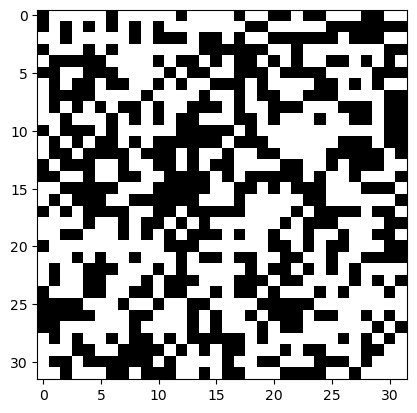


[1 0 1 ... 0 0 0]

distance between perturbed input state and stored state:  [90.0]


In [8]:
P = Perturb(WS, p=90)#perturbed input state matrix
k = 1 #np.random.randint(len(W))
#print(k)
in_k=P[k:k+1,]#perturbed input state
in_W_k=WS[k:k+1,]# setting in_W_k to be from the k-th column to the (k+1)_th column thus only the k-th collumn since RHS of : is not included(excluded in the list)
in_W = np.reshape(in_W_k,(np.size(in_W_k),))

grid = in_k.reshape((32, 32))
grid = np.logical_not(grid) # Invert the grid
fig, ax = plt.subplots()
ax.imshow(grid, cmap='gray', vmin=0, vmax=1)
plt.show()
print()
print(W[0,:])
print()
print('distance between perturbed input state and stored state: ', Hamming(in_k, in_W_k))

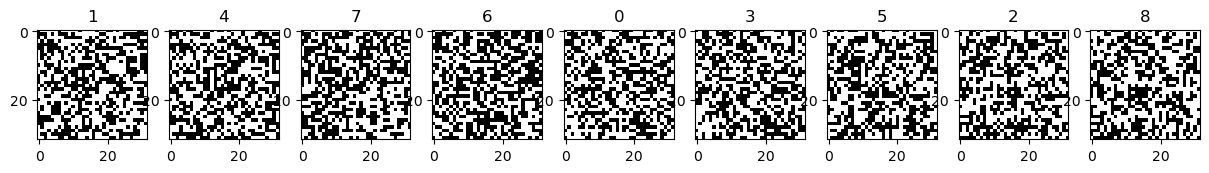


final stable state:  8

Final associative chain:  [1 4 7 6 0 3 5 2 8]

[[0 0 1 ... 0 0 1]]


In [9]:
perm = np.arange(1024)
link_find = 9
l = 0
e =  np.zeros(link_find*len(perm))
hammings = np.zeros(n)
amc = np.zeros(n).astype(int)
associative_chain = np.zeros(link_find).astype(int)
fig, axs = plt.subplots(1, link_find, figsize=(15, 5))
att = 0
for i in range(link_find):
    q = 0
    random.shuffle(perm)
    for j in range(len(perm)):
        k=perm[j]
        e[l] = Energy2(WS,in_k)
        y,amc = update(in_k, WS, k, amc, q == 0, i, att)
        #rint(amc, i)
        q=1
        l=l+1
        in_k = y
    associative_chain[i] = stable_state(in_k, WS)
    att = 1
    
    grid = in_k.reshape((32, 32))
    grid = np.logical_not(grid) # Invert the grid
    axs[i].imshow(grid, cmap='gray', vmin=0, vmax=1)
    axs[i].set_title('{}'.format(associative_chain[i]))

plt.show()
print()

for i in range(n):
    hammings[i] = Hamming(in_k, WS[i:i+1,])[0]


print('final stable state: ', stable_state(in_k, WS))
print()

print('Final associative chain: ', associative_chain)
print()
print(in_k)

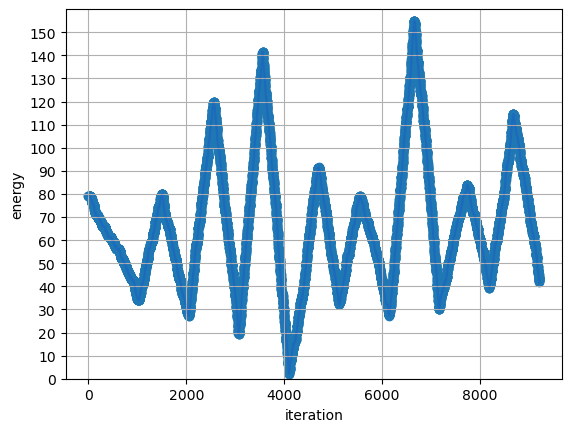

In [10]:
# Set the domain size
h = link_find*len(perm)

# Generate the x-axis data points (domain)
dom = np.arange(h)

# Create the scatter plot
plt.scatter(dom, e)

# Interpolate the scatter plot using linear splines
spline = plt.plot(dom, e, 'b', linestyle='-', alpha=0.1)

# Set the axis labels
plt.xlabel('iteration')
plt.ylabel('energy')

# Set y-axis limits and ticks
y_ticks = np.arange(0, 160, 10)
plt.ylim([0, 160])
plt.yticks(y_ticks)

# Display the plot
plt.grid(True)
plt.show() # energy from [[-3315368.47]] or [[-3262098.56]] to [[-12549090.72]]

print() 
